# Simulating Quorum Delegation on cadCAD

> *Danilo Lessa Bernardineli, October 2023*

This model is a subset of the Neural Quorum Governance model as in https://github.com/BlockScience/neural-quorum-governance/tree/main

## Part 1: Pre-requisites

In [1]:
from dataclasses import dataclass
from functools import reduce
from typing import Annotated, TypedDict, Union, Callable
from cadCAD_tools.types import *
from cadCAD_tools.execution import easy_run
from random import random, normalvariate, seed
from copy import deepcopy, copy
from functools import reduce
from enum import Enum, auto
import pandas as pd
import colorsys
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from scipy.stats import poisson, bernoulli  # type: ignore
from netgraph import Graph
from random import choice, sample, random
pio.renderers.default = "png" # For GitHub rendering

## Part 2. Module Logic

### Model Types & Classes

In [2]:
from typing import Annotated, TypedDict, Union, Callable
from dataclasses import dataclass
from enum import Enum, auto

Days = Annotated[float, 'days']  # Number of days
UserUUID = str
ProjectUUID = str
VotingPower = float
PastRoundIndex = int
DelegationGraph = dict[UserUUID, list[UserUUID]]

class ReputationCategory(Enum):
    Tier3 = auto()
    Tier2 = auto()
    Tier1 = auto()
    Uncategorized = auto()

class Vote(float, Enum):
    """
    The Voting Actions towards a Project that a User can take and the 
    values in terms of Voting Power.
    """
    Yes = 1.0
    No = -1.0
    Abstain = 0.0

class Action(Enum):
    """
    The Decisions that a User can make in a Round.
    """
    RoundVote = auto()
    Delegate = auto()
    Abstain = auto()

@dataclass
class User():
    label: UserUUID
    reputation: ReputationCategory
    active_past_rounds: set[PastRoundIndex]


ActionMatrix = dict[UserUUID, dict[ProjectUUID, Vote]]
VotingMatrix = dict[UserUUID, dict[ProjectUUID, VotingPower]]
PerProjectVoting = dict[ProjectUUID, VotingPower]

### Model State & Parameter Space definition

In [3]:
class QDModelState(TypedDict):
    days_passed: Days
    delta_days: Days
    users: list[User]

    user_round_decisions: dict[UserUUID, Action]
    action_matrix: ActionMatrix
    vote_matrix: VotingMatrix
    per_project_voting: PerProjectVoting


class QDModelParams(TypedDict):
    label: str
    timestep_in_days: Days

    # Quorum Delegation Parameters
    quorum_agreement_weight_yes: float
    quorum_agreement_weight_no: float
    quorum_agreement_weight_abstain: float
    max_quorum_selected_delegates: int
    max_quorum_candidate_delegates: int
    quorum_delegation_absolute_threshold: float
    quorum_delegation_relative_threshold: float

    # Exogenous parameters
    projects: set[ProjectUUID]

    # Behavioral Parameters
    avg_new_users_per_day: float
    avg_user_past_votes: float
    new_user_action_probability: float
    new_user_round_vote_probability: float
    new_user_project_vote_probability: float
    new_user_project_vote_yes_probability: float
    new_user_average_delegate_count: float
    new_user_min_delegate_count: int


### Auxiliary Logic

In [4]:
def retrieve_prev_state_users(history):
    if len(history) > 1:
        previous_state_users = set(u.label 
                                for u 
                                in history[-1][-1]['users'])
    else:
        previous_state_users = set()
    return previous_state_users

def vote_from_quorum_delegation(user_quorum: list[UserUUID],
                                project_id: ProjectUUID,
                                action_matrix: ActionMatrix,
                                user_decisions: dict[UserUUID, Action],
                                params: QDModelParams) -> Vote:
    """
    Compute the quorum agreement for the active participants
    """
    # Filter User quorum for actively voting users only.
    valid_delegates = [u
                       for u, d in user_decisions.items()
                       if d == Action.RoundVote
                       and u in user_quorum]

    # Select up to the max quorum selected delegates parameter
    if len(valid_delegates) > params['max_quorum_selected_delegates']:
        selected_delegates = valid_delegates[:
                                             params['max_quorum_selected_delegates']]
    else:
        selected_delegates = valid_delegates

    # Compute Quorum Agreement and Size.
    agreement = 0.0
    quorum_size = 0
    for delegate in selected_delegates:
        delegatee_actions = action_matrix.get(delegate, {})
        action = delegatee_actions.get(project_id, None)
        if action is not None:
            quorum_size += 1
            if action is Vote.Yes:
                agreement += params['quorum_agreement_weight_yes']
            elif action is Vote.No:
                agreement += params['quorum_agreement_weight_no']
            else:
                agreement += params['quorum_agreement_weight_abstain']

    # Compute Absolute and Relative agreement fractions
    absolute_agreement = agreement / params['max_quorum_selected_delegates']
    if quorum_size > 0:
        relative_agreement = agreement / quorum_size
    else:
        relative_agreement = 0.0

    # Resolve vote as per quorum consensus
    if abs(absolute_agreement) >= params['quorum_delegation_absolute_threshold']:
        if abs(relative_agreement) >= params['quorum_delegation_relative_threshold']:
            if relative_agreement > 0:
                return Vote.Yes
            else:
                return Vote.No
        else:
            return Vote.Abstain
    else:
        return Vote.Abstain

### Model Block Logic Definitions

In [5]:

def generic_policy(_1, _2, _3, _4) -> dict:
    """Function to generate pass through policy

    Args:
        _1
        _2
        _3
        _4

    Returns:
        dict: Empty dictionary
    """
    return {}


def replace_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value))


def add_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value) + state[variable])



def p_evolve_time(params: QDModelParams, _2, _3, _4) -> Signal:
    return {'delta_days': params['timestep_in_days']}

def s_days_passed(_1, _2, _3,
                  state: QDModelState,
                  signal: Signal) -> VariableUpdate:
    return ('days_passed', state['days_passed'] + signal['delta_days'])

def s_delta_days(_1, _2, _3, _4, signal: Signal) -> VariableUpdate:
    return ('delta_days', signal['delta_days'])


def s_onboard_users(params: QDModelParams, _2, _3, state: QDModelState, _5) -> VariableUpdate:
    """
    Onboard N new users and their relevant properties for QD
    through stochastic processes.

    XXX: the new user reputation is chosen from the `ReputationCategory` enum
    with every option having equal weight.
    XXX: the active past rounds for the new user is randomly sampled
    from the list of past rounds with equal weights. The amount of samples
    is based on a capped poisson sample.
    """
    new_user_list = deepcopy(state['users'])

    avg_new_users_per_ts = params['avg_new_users_per_day'] * params['timestep_in_days']
    new_users: int = poisson.rvs(avg_new_users_per_ts)

    past_round_choices = params['past_rounds']
    reputation_choices = list(ReputationCategory) # TODO: parametrize

    for i in range(new_users):
        past_voting_n = min(poisson.rvs(params['avg_user_past_votes']), 
                            len(past_round_choices))

        new_user = User(label=len(new_user_list) + i,
                        reputation=choice(reputation_choices),
                        active_past_rounds=set(sample(past_round_choices, past_voting_n)))
        
        new_user_list.append(new_user)

    return ('users', new_user_list)

def p_user_vote(params: QDModelParams,
                 _2,
                 history: dict[int, dict[int, QDModelState]], 
                 state: QDModelState) -> Signal:
    """
    Make new users decide on their actions: Abstain, Vote or Delegate

    XXX: Bernoulli processes are used for all of the following:
        - determining the probability of a user participating (actively or delegating) or not.
        - determine whatever the user will actively vote or delegate
        - determine if the user will vote on a project or not
        - determine if the user will vote yes or no on a project 
    XXX: Poisson processes are used for all of the following:
        - determine how much delegatees an user will have if he opted to delegate 
    """
    delegates: DelegationGraph = deepcopy(state['delegatees'])
    action_matrix: ActionMatrix = deepcopy(state['action_matrix'])
    decisions: dict[UserUUID, Action] = deepcopy(state['user_round_decisions'])

    current_users = set(u.label 
                     for u 
                     in state['users'])
    
    previous_state_users = retrieve_prev_state_users(history)

    new_users = current_users - previous_state_users

    for user in new_users:
        action_matrix[user] = {}
        if bernoulli.rvs(params['new_user_action_probability']):
            if bernoulli.rvs(params['new_user_round_vote_probability']):
                decisions[user] = Action.RoundVote
                # Active vote
                for project in params['projects']:
                    if bernoulli.rvs(params['new_user_project_vote_probability']):
                        if bernoulli.rvs(params['new_user_project_vote_yes_probability']):
                            project_vote = Vote.Yes
                        else:
                            project_vote = Vote.No
                    else:
                        project_vote = Vote.Abstain
                    action_matrix[user][project] = project_vote
            else:
                decisions[user] = Action.Delegate
                mu = params['new_user_average_delegate_count'] - params['new_user_min_delegate_count']
                delegate_count = poisson.rvs(mu)
                delegate_count += params['new_user_min_delegate_count']
                if delegate_count > len(previous_state_users):
                    delegate_count = len(previous_state_users)

                if delegate_count < params['new_user_min_delegate_count']:
                    pass
                else:
                    user_delegates = sample(previous_state_users, delegate_count)
                    delegates[user] = user_delegates
        else:
            decisions[user] = Action.Abstain

    return {'delegatees': delegates,
            'action_matrix': action_matrix, 
            'user_round_decisions': decisions}


def p_compute_votes(params: QDModelParams, _2, _3, state: QDModelState) -> Signal:
    """
    Perform Neural Quorum Governance
    """
    action_vote_matrix: ActionMatrix = deepcopy(state['action_matrix'])
    per_project_voting: PerProjectVoting = deepcopy(state['per_project_voting'])

    # Compute Abstainin users action matrix
    abstaining_users = set(u for u, d in state['user_round_decisions'].items()
                        if d == Action.Abstain)
    
    for user_id in abstaining_users:
        action_vote_matrix[user_id] = {}
        for project in params['projects']:
            action_vote_matrix[user_id][project] = Vote.Abstain
    
    # Compute Delegatees action matrix with Quorum Delegation
    delegating_users = set(u for u, d in state['user_round_decisions'].items()
                        if d == Action.Delegate)
    for user_id in delegating_users:
        action_vote_matrix[user_id] = {}
        for project in params['projects']:
            vote = vote_from_quorum_delegation(state['delegatees'].get('user', []),
                                        project,
                                        state['action_matrix'],
                                        state['user_round_decisions'],
                                        params)
            action_vote_matrix[user_id][project] = vote

    # Compute vote matrix with an 1 vote = 1 power mechanism
    vote_matrix: VotingMatrix = {}
    for user_id, votes in action_vote_matrix.items():
        vote_matrix[user_id] = {}
        for project, vote in votes.items():
            power = float(vote) # Use the Vote Enum value as the power.
            vote_matrix[user_id][project] = vote * power
            if project in per_project_voting:
                per_project_voting[project] += vote_matrix[user_id][project]
            else:
                per_project_voting[project] = vote_matrix[user_id][project]

    return {'vote_matrix': vote_matrix,
            'per_project_voting': per_project_voting}

### Model Block Structure Definitions

In [6]:
QD_MODEL_BLOCKS: list[dict] = [
    {
        'label': 'Time Tracking',
        'ignore': False,
        'desc': 'Updates the time in the system',
        'policies': {
            'evolve_time': p_evolve_time
        },
        'variables': {
            'days_passed': s_days_passed,
            'delta_days': s_delta_days
        }
    }, 
    {
        'label': 'Onboard users',
        'policies': {},
        'variables': {
            'users': s_onboard_users
        }
    },
    {
        'label': 'Trust & Vote',
        'policies': {
            'user_vote': p_user_vote
        },
        'variables': {
            'delegatees': replace_suf,
            'action_matrix': replace_suf,
            'user_round_decisions': replace_suf
        }
    },
    {
        'label': 'Tally votes according to Neural Quorum Governance',
        'policies': {
            'tally votes': p_compute_votes
        },
        'variables': {
            'vote_matrix': replace_suf,
            'per_project_voting': replace_suf
        }
    }
]


QD_MODEL_BLOCKS = [block for block in QD_MODEL_BLOCKS
                              if block.get('ignore', False) is False]

# Post Processing

blocks: list[dict] = []
for block in [b for b in QD_MODEL_BLOCKS if b.get('ignore', False) != True]:
    _block = deepcopy(block)
    for variable, suf in block.get('variables', {}).items():
        if suf == add_suf:
            _block['variables'][variable] = add_suf(variable)
        elif suf == replace_suf:
            _block['variables'][variable] = replace_suf(variable)
        else:
            pass
    blocks.append(_block)

QD_MODEL_BLOCKS = deepcopy(blocks)

## Part 3. cadCAD Simulation

### Simulation Initial State & Parameters

In [7]:

TIMESTEPS = 100
SAMPLES = 1

N_INITIAL_USERS = 6
N_PROJECTS = 15
N_PAST_ROUNDS = 5

AVERAGE_PAST_VOTES_PER_USER = 1.5
PAST_ROUNDS = set(i for i in range(N_PAST_ROUNDS))

DEFAULT_PROJECTS = set(f"proj_{i}" for i in range(N_PROJECTS))

INITIAL_STATE = QDModelState(
    days_passed=0.0,
    delta_days=None,
    users=[],
    user_round_decisions={},
    delegatees={},
    action_matrix={},
    vote_matrix={},
    per_project_voting={}
)

SINGLE_RUN_PARAMS = QDModelParams(
    label='default_run',
    timestep_in_days=1.0,
    quorum_agreement_weight_yes=1.0,
    quorum_agreement_weight_no=-1.0,
    quorum_agreement_weight_abstain=0.0,
    max_quorum_selected_delegates=5,
    max_quorum_candidate_delegates=10,
    quorum_delegation_absolute_threshold=1/2,
    quorum_delegation_relative_threshold=2/3,
    initial_power=0.0,
    past_rounds=PAST_ROUNDS,
    projects=DEFAULT_PROJECTS,
    avg_new_users_per_day=1.0,
    avg_user_past_votes=AVERAGE_PAST_VOTES_PER_USER,
    new_user_action_probability=0.5,
    new_user_round_vote_probability=0.5,
    new_user_project_vote_probability=5/N_PROJECTS,
    new_user_project_vote_yes_probability=0.8,
    new_user_average_delegate_count=6.5,
    new_user_min_delegate_count=5,
    new_user_average_trustees=7.0

)

## Part 4. Results

In [8]:
default_run_args = (INITIAL_STATE,
                     {k: [v] for k, v in SINGLE_RUN_PARAMS.items()},
                    QD_MODEL_BLOCKS,
                    TIMESTEPS,
                    SAMPLES)
sim_df = easy_run(*default_run_args, assign_params=False).set_index('days_passed')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 21, 1, 8)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 21, 1, 8)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_36117/3720667403.py:78: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_36117/3720667403.py:137: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.



Flattening results:   0%|          | 0/401 [00:00<?, ?it/s]

Total execution time: 0.49s


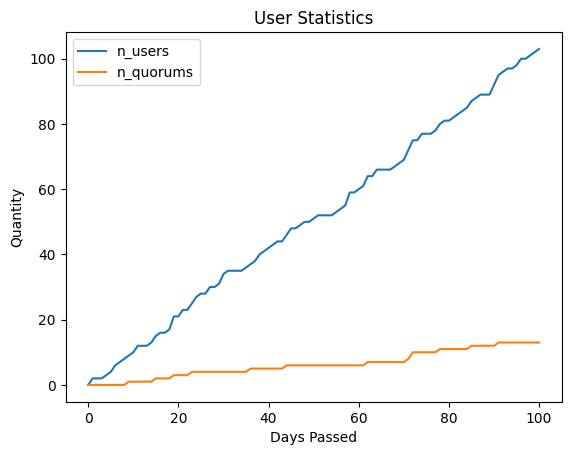

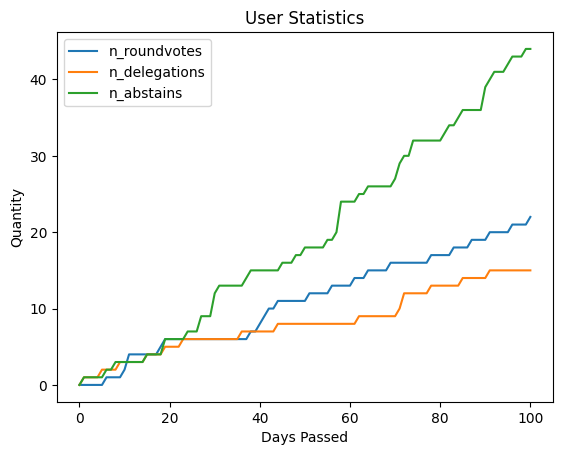

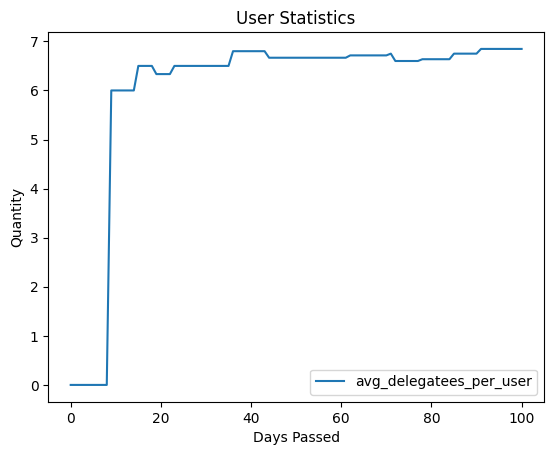

In [9]:
# Global metrics

metrics = {
    'n_users': lambda row: len(row.users),
    'n_quorums': lambda row: len(row.delegatees),
    'n_roundvotes': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.RoundVote]),
    'n_delegations': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Delegate]),
    'n_abstains': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Abstain]),
    'avg_delegatees_per_user': lambda row: sum(len(l) for l in row.delegatees.values()) / len(row.delegatees) if len(row.delegatees) > 0 else 0.0,
}



new_df = sim_df.apply(metrics.values(), axis='columns')
new_df.columns = list(metrics.keys())

new_df[['n_users', 'n_quorums']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

new_df[['n_roundvotes', 'n_delegations', 'n_abstains']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()


new_df[['avg_delegatees_per_user']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

In [10]:
def render_delegation_graphs(i):
    t = sim_df.iloc[i].name
    delegatee_graph_per_day = sim_df.delegatees.map(nx.DiGraph)

    def sample_colors_from_hue(N):
        import colorsys
        HSV_tuples = [(x*1.0/N, 1.0, 0.8) for x in range(N)]
        RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
        return list(RGB_tuples)

    cmap = matplotlib.colormaps['BrBG']

    def render_graph(G, 
                    weights,
                    K=1, 
                    q=1, 
                    title="", 
                    a=1, 
                    node_color=None,
                    edge_color=None,
                    edge_alpha=0.5,
                    edge_width=0.1,
                    **kwargs):
        sizes = {k: a + K * v ** q for k, v in weights.items()}
        if node_color is None:
            node_color = {k: cmap(i / len(weights)) for i, k in enumerate(sorted(weights.keys()))}
        else:
            pass
        fig = plt.figure(figsize=(10, 2), dpi=200) 
        ax = fig.add_subplot(1, 1, 1)
        g = Graph(G, 
                ax=ax,
                node_size=sizes,
                node_edge_width=0,
                edge_width=edge_width,
                node_color=node_color,
                edge_alpha=edge_alpha,
                edge_color=edge_color,
                **kwargs)
        ax.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.9))
        fig.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.9))
        plt.title(title, fontname='Helvetica')
        plt.show()

    G = delegatee_graph_per_day.iloc[i]
    weights = {k: 0 for k in G.nodes}
    weights |= {k: len(v) * 0.2 for k, v in sim_df.iloc[i].delegatees.items()}
    quorums = sim_df.iloc[i].delegatees
    source_color_map = {k: matplotlib.colormaps['tab10'](i/len(quorums))
                        for i, k in enumerate(quorums.keys())}
    edge_color = {(a,b): source_color_map[a] for (a, b) in G.edges}
    render_graph(G, weights, 
                K=0, 
                q=1, 
                a=2, 
                title=f'Delegation Graph at day {t:.0f}', 
                edge_color=edge_color,
                edge_width=1.0,
                edge_alpha=0.9,
                arrows=True,
                edge_layout='curved',
                node_layout='spring',
                scale=(4,1))

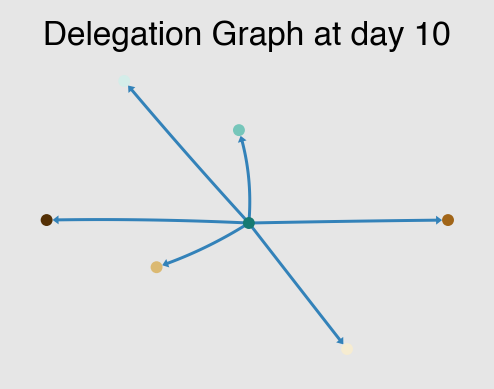

In [11]:
render_delegation_graphs(10)

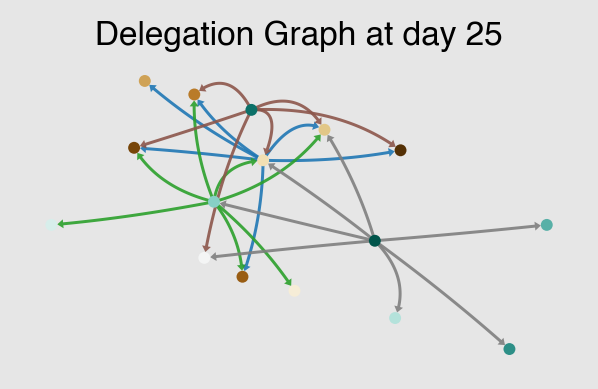

In [12]:
render_delegation_graphs(25)

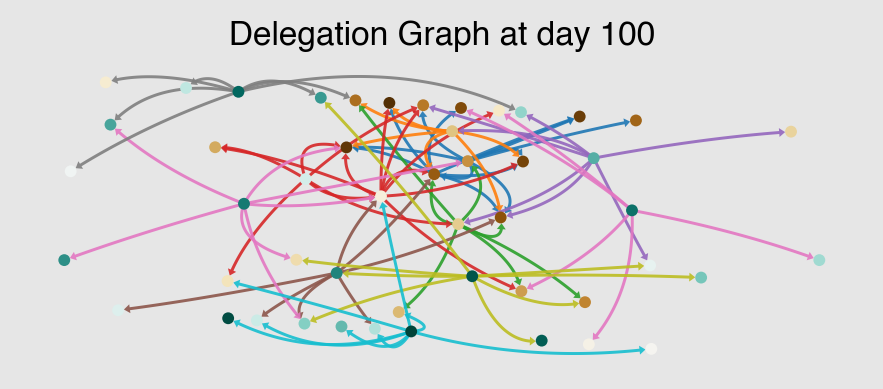

In [13]:
render_delegation_graphs(100)